# Lab 3: Gaussian Process Regression

In [1]:
% pylab inline
import numpy as np
import pandas as pd
import pylab as pb
import GPy
import seaborn as sns
pb.ion()

Populating the interactive namespace from numpy and matplotlib


 /Users/juangilopez/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


First we'll analize de gathered data to determine the noise fo he measurements

<class 'pandas.core.frame.DataFrame'>


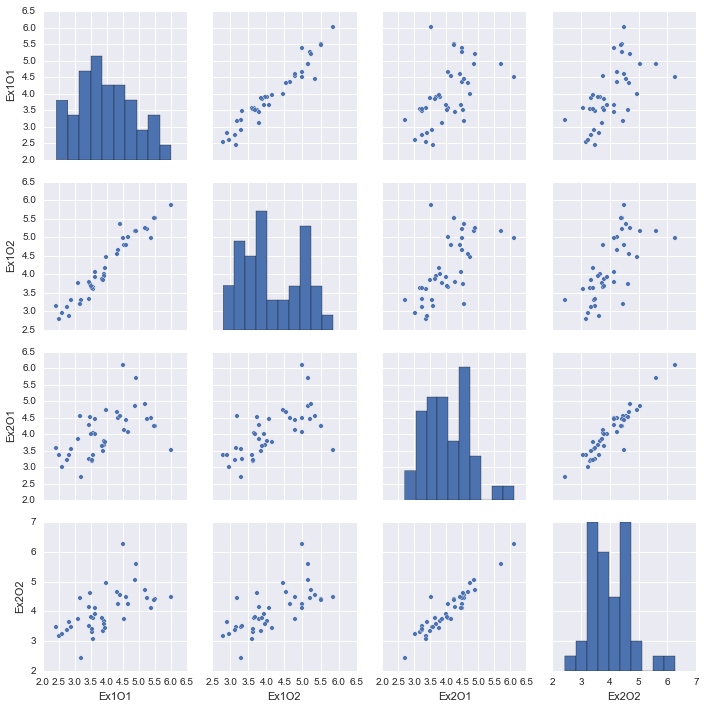

In [2]:
df = pd.read_csv('helicopterTrials.csv',names=['Ex1O1', 'Ex1O2', 'Ex2O1', 'Ex2O2'])
print type(df)
sns.pairplot(df)

In [16]:
exp1 = np.array(df[['Ex1O1', 'Ex1O2']])
exp2 = np.array(df[['Ex2O1', 'Ex2O2']])
superexp = np.array(df[['Ex1O1', 'Ex1O2', 'Ex2O1', 'Ex2O2']])
exp1 = np.mean(exp1, axis=1)
exp2 = np.mean(exp2, axis=1)
data = np.loadtxt('X.csv', delimiter=',')
exp1 = exp1[:,None]
exp2 = exp2[:,None]
data = np.hstack((data[0:40,:], np.mean(superexp, axis=1)[:,None]))
#names = ["Wing-length", "Wing-width", "Tail-length", "Arm-length", "T1"]
#dataplot = pd.DataFrame(data=data, columns=names)
#sns.pairplot(dataplot)

In [19]:

##################################################################
##                           helpers                            ##
##################################################################

## coordinate change

def angle(X):
    # input X is ["Wing-length", "Wing-width", "Tail-length", "Arm-length"]
    # output is the angle (in degrees) between the tail and the wing
    return(180/np.pi*np.arccos(-1.*((X[:,3]-2.5)**2-(X[:,2]-2.5)**2-X[:,0]**2)/(2*(X[:,2]-2.5)*X[:,0])))

# mapping to the new space
def old2new(X):
    # input X is ["Wing-length", "Wing-width", "Tail-length", "Arm-length"]
    # output Y is ['wing angle', 'wing area','total length', 'wing_l / tail_l ratio']
    Y = 0*X
    Y[:,0] = angle(X)
    Y[:,1] = X[:,0] * X[:,1]  
    Y[:,2] = X[:,0] + X[:,2] + X[:,3] 
    Y[:,3] = X[:,0] / (X[:,2] - 2.5)
    return(Y)

# mapping back to the original space
def new2old(Y):
    # input Y is ['wing angle', 'wing area','total length', 'wing_l / tail_l ratio']
    # output X is ["Wing-length", "Wing-width", "Tail-length", "Arm-length"]
    X = 0*Y
    f_1 = np.sqrt(1+(1/Y[:,3])**2-2*np.cos(Y[:,0]*np.pi/180)*(1/Y[:,3]))
    X[:,0] = (Y[:,2]-5) / (1 + 1./Y[:,3] + f_1)
    X[:,1] = Y[:,1] / X[:,0]
    X[:,2] = X[:,0] / Y[:,3] + 2.5
    X[:,3] = Y[:,2] - X[:,0] - X[:,2]
    return(X)

## error measures

def Q2(F,mX):
	return(1-sum((F-mX)**2)/sum((F-np.mean(F))**2))

def leaveOneOut(m):
    n = m.X.shape[0]
    mean = np.zeros(n)
    var = np.zeros(n)
    kern = m.kern
    for i in range(n):
        Xloo = np.delete(m.X,i,0)
        Yloo = np.delete(m.Y,i,0)
        mloo = GPy.models.gp_regression.GPRegression(Xloo, Yloo, kern.copy())
        mloo[:] = m[:]
        mean[i],var[i] = mloo.predict(X[i:i+1,:])
    return(mean,var)


##############################
# Question 1

# load data
#data = # TODO: load your data here

X = data[:,0:4]#,data[:,0:4]))
F = data[:,4:5]#,data[:,5:6]))

n, d = X.shape

## choose the new parameterization and rescale for convenience
X =  old2new(X)
limits = np.array([75,115,20,35,22,31,0.65,1.6]).reshape(4,2).T
X = (X-limits[0:1,:])/(limits[1:2,:]-limits[0:1,:])

F = F-np.mean(F)

# look at noise variance
tau2 = 0.01#np.var(data[:,4]-data[:,5])/2.

In [20]:
##############################
# Question 2

# define a kernel
def GPreg(X, F, d):
    kern0 = GPy.kern.Matern32(input_dim=d,variance=np.var(F),lengthscale=[.5]*d,ARD=True)
    kern1 = GPy.kern.RBF(input_dim=d,variance=0.01,lengthscale=[.1]*d,ARD=True)
    kern2 = GPy.kern.RBF(input_dim=d,variance=0.05,lengthscale=[.5]*d,ARD=True)
    kern = kern0 #+ kern1 + kern2
    #print kern
    #kern['.*lengthscale'] # get more details about length-scales
    # define a model
    m = GPy.models.gp_regression.GPRegression(X, F, kern)
    #print m
    # optimize the model parameters
    m.optimize()
    #m.optimize_restarts(num_restarts=10)
    #print m
    #m['.*lengthscale']
    return m

# predict at points Xnew
m = GPreg(X, F, d)
Xnew = np.random.uniform(0,1,(3,d))
Xnew = Xnew*(np.max(X,axis=0)-np.min(X,axis=0)) + np.min(X,axis=0)
mean, var = m.predict(Xnew)
print mean
print "IMSE =", round(np.mean(var),2)

[[-0.79407595]
 [-0.12925449]
 [-0.71571071]]
IMSE = 0.21


0.451847406632


(<matplotlib.text.Text at 0x115d337d0>, <matplotlib.text.Text at 0x115e70590>)

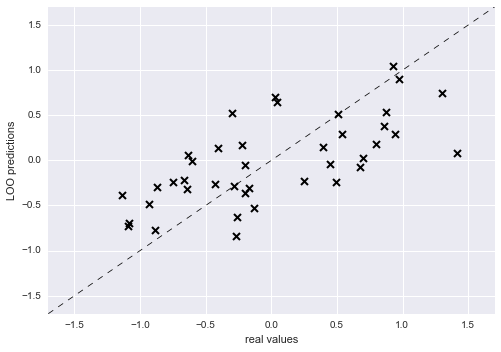

In [26]:
##############################
# Question 3

def OurLeaveOneOut(X,F,d):
    N = X.shape[0]
    limit = N#/2
    ret = np.zeros((N,2))
    m = GPreg(X, F, d)
    kern = m.kern
    for i in range(0,limit):
        idx = np.ones(N, dtype=bool)
        idx[i] = 0
        #idx[i + limit] = 0
        X_train = X[idx, :]
        F_train = F[idx, :]
        mloo = GPy.models.gp_regression.GPRegression(X_train, F_train, kern.copy())
        mloo[:] = m[:]
        idx_test = np.logical_not(idx)
        Xtest = X[idx_test,:]
        #print Xtest
        mean, var = mloo.predict(Xtest)
        ret[i,0] = mean[0,0]
        ret[i,1] = var[0,0]
    
    return ret[:,0][:,None], ret[:,1][:,None]
    
#mloo, vloo = OurLeaveOneOut(X,F,d)# TODO: write "leave two out " function and compute predictions
#print mloo.shape, vloo.shape
m = GPreg(X, F, d)
mloo, vloo = leaveOneOut(m)
print Q2(F.flatten(),mloo.flatten())

pb.figure()
pb.plot(F,mloo,'kx',mew=2)
pb.plot((-2,2),(-2,2),'k--',linewidth=.75)
pb.xlim((-1.7,1.7)), pb.ylim((-1.7,1.7))
pb.xlabel('real values'),pb.ylabel('LOO predictions')

##############################
# Question 4


##############################
# Question 5


##############################
# Question 6

In [27]:
print m


Name                              : GP regression
Log-likelihood                    : -34.656619036
Number of Parameters              : 6
Number of Optimization Parameters : 6
Updates                           : True
Parameters:
  GP_regression.           |      Value       |  Constraint  |  Prior  |  Tied to
  Mat32.variance           |  0.380216784293  |     +ve      |         |         
  Mat32.lengthscale        |            (4,)  |     +ve      |         |         
  Gaussian_noise.variance  |  0.101606779547  |     +ve      |         |         
